### First, let's import the necessary libraries.

In [5]:
import numpy as np
import time
import gym
from gym import spaces
from IPython.display import clear_output
from operator import add
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
plt.style.use('dark_background')


### Now, let's create our custom `DisasterZone` gym environment.

In [6]:
class DisasterZone(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=10, num_obstacles=15, num_survivors=5, num_charging_stations=3, max_battery_life=50):

        super(DisasterZone, self).__init__()

        self.grid_size = grid_size
        self.num_obstacles = num_obstacles
        self.num_survivors = num_survivors
        self.num_charging_stations = num_charging_stations
        self.max_battery_life = max_battery_life

        self.action_space = spaces.Discrete(4)
        self.actions_dict = {
            0: (-1, 0), # Up
            1: (1, 0),  # Down
            2: (0, -1), # Left
            3: (0, 1)   # Right
        }
        # 0: Empty, 1: Obstacle, 2: Survivor, 3: Charging Station
        self.observation_space = spaces.Box(
            low=0, high=3, shape=(grid_size, grid_size), dtype=np.int32)

        self.reset()

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)
        self.agent_pos = (0, 0)
        self.survivors = {}
        self.battery_life = self.max_battery_life

        # Randomly placing obstacles in the grid
        for _ in range(self.num_obstacles):
            pos = self._random_empty_position()
            self.grid[pos] = 1

        # Randomly placing survivors in the grid
        for i in range(self.num_survivors):
            pos = self._random_empty_position()
            self.grid[pos] = 2
            self.survivors[pos] = i

        # Randomly placing charging stations in the grid
        for _ in range(self.num_charging_stations):
            pos = self._random_empty_position()
            self.grid[pos] = 3

        return self.grid

    def step(self, action):
        # Copy of the current agent position
        old_pos = self.agent_pos

        # Calculate the new position
        new_pos = tuple(map(add, self.agent_pos, self.actions_dict[action]))

        # Ensure the agent does not move outside the grid
        new_pos = (max(min(new_pos[0], self.grid_size - 1), 0), max(min(new_pos[1], self.grid_size - 1), 0))

        # Default battery consumption for moving to a new position
        battery_consumption = 1

        # Reward for moving into an empty cell
        reward = -2
        done = False

        hit_obstacle = False  # Flag to track if the agent attempted to move into an obstacle

        if self.grid[new_pos] == 1:  # Obstacle
            reward = -3
            hit_obstacle = True  # The agent attempted to move into an obstacle
        elif self.grid[new_pos] == 2:  # Survivor
            euclidean_distance = np.linalg.norm(
                np.array(new_pos) - np.array(old_pos))
            reward = max(5 - int(euclidean_distance), 1)
            self.grid[new_pos] = 0
            if new_pos in self.survivors:
                del self.survivors[new_pos]
            done = len(self.survivors) == 0
        elif self.grid[new_pos] == 3:  # Charging Station
            # Charging the battery instead of consuming it
            battery_consumption = -3

        # Update agent's battery life
        self.battery_life -= battery_consumption

        # Check if the battery life has run out
        if self.battery_life <= 0:
            done = True

        # Calculate reward penalty for low battery life
        reward -= self.max_battery_life - self.battery_life

        # Update agent's position
        self.agent_pos = new_pos

        return self.grid, reward, done, {"hit_obstacle": hit_obstacle}

    def render(self, mode='human'):
        grid = self.grid.copy()
        grid[self.agent_pos] = 4

        symbol_mapping = {0: '.', 1: 'X', 2: 'S', 3: 'C', 4: 'A'}
        for row in grid:
            print(' '.join([symbol_mapping[cell] for cell in row]))
            print()

    def close(self):
        pass

    def _random_empty_position(self):
        # Finding all the empty positions in the grid where it's not the top-left corner
        empty_positions = np.argwhere((self.grid == 0) & (
            np.arange(self.grid.size).reshape(self.grid.shape) != 0))
        return tuple(empty_positions[np.random.randint(len(empty_positions))])
    

### Let's create a Q-learning agent to learn a policy in the `DisasterZone`. The agent will learn a Q-table that represents the expected future rewards for each state-action pair.

In [7]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def _state_key(self, state, agent_pos):
        return (tuple(state.flatten()), agent_pos)

    def _get_q(self, state, agent_pos, action):
        state_key = self._state_key(state, agent_pos)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.env.action_space.n)
        return self.q_table[state_key]

    def _choose_action(self, state, agent_pos):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            q_values = self._get_q(state, agent_pos, None)
            return np.argmax(q_values)

    def _update_q(self, state, agent_pos, action, next_state, next_agent_pos, reward, done):
        q_values = self._get_q(state, agent_pos, action)
        next_q_values = self._get_q(next_state, next_agent_pos, None)
        next_action = self._choose_action(next_state, next_agent_pos)

        if done:
            q_values[action] += self.alpha * (reward - q_values[action])
        else:
            q_values[action] += self.alpha * \
                (reward + self.gamma *
                 next_q_values[next_action] - q_values[action])

    def learn(self, num_episodes):
        rewards = []
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0

            while not done:
                action = self._choose_action(state, self.env.agent_pos)
                next_state, reward, done, _ = self.env.step(action)
                self._update_q(state, self.env.agent_pos, action,
                               next_state, self.env.agent_pos, reward, done)
                state = next_state

                episode_reward += reward

                self.visualize_training(reward, episode_reward, done)

            rewards.append(episode_reward)

            print_mode = 1

            if print_mode == 0: # Print all episodes stats
                print(
                    f"#### Episode {episode + 1}/{num_episodes} finished with cumulative reward: {episode_reward} and survivors rescue rate: {1 - len(self.env.survivors) / self.env.num_survivors} ####")
                time.sleep(0.8)
                print()
                clear_output(wait=True)
            elif print_mode == 1: # Print only final episode stats
                if episode == num_episodes - 1:
                    print(
                        f"#### Episode {episode + 1}/{num_episodes} finished with cumulative reward: {episode_reward} and survivors rescue rate: {1 - len(self.env.survivors) / self.env.num_survivors} ####")
            else: # Print nothing
                pass

        return rewards

    def train(self, num_episodes):
        return self.learn(num_episodes)
    
    def visualize_training(self, reward, episode_reward, done):
        self.env.render(mode='human')
        print(
            f"Step Reward: {reward}, Cumulative Episode Reward: {episode_reward}, Battery Life: {self.env.battery_life}, Survivors Left: {len(self.env.survivors)}")
        print()

        clear_output(wait=True)

        if not done:
            time.sleep(0.5)

    def get_q_table(self):
        return self.q_table


### Now, let's instantiate a `DisasterZone` environment and a Q-learning agent to learn a policy in the `DisasterZone`. The agent will learn a Q-table that represents the expected future rewards for each state-action pair.

#### Episode 500/500 finished with cumulative reward: 3758300 and survivors rescue rate: 1.0 ####


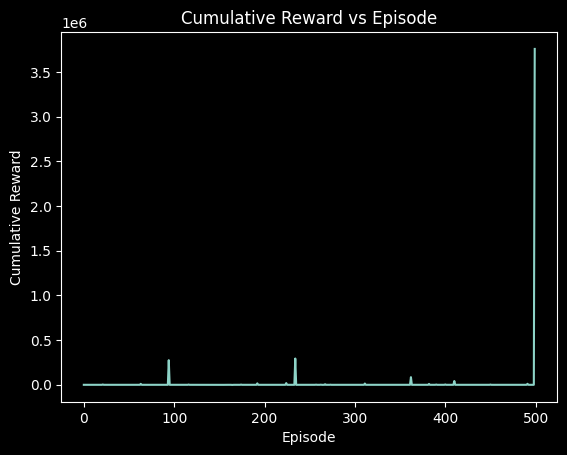

In [54]:
env = DisasterZone(grid_size=4, num_obstacles=5, num_survivors=4,
                   num_charging_stations=2, max_battery_life=20)

agent = QLearningAgent(env)

num_episodes = 500

rewards = agent.train(num_episodes)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward vs Episode')
plt.show()


### The previous results aren't that great, hence, let's train the Q-learning agent for an intensive 1 million episodes.

#### Episode 1000000/1000000 finished with cumulative reward: -250 and survivors rescue rate: 0.0 ####


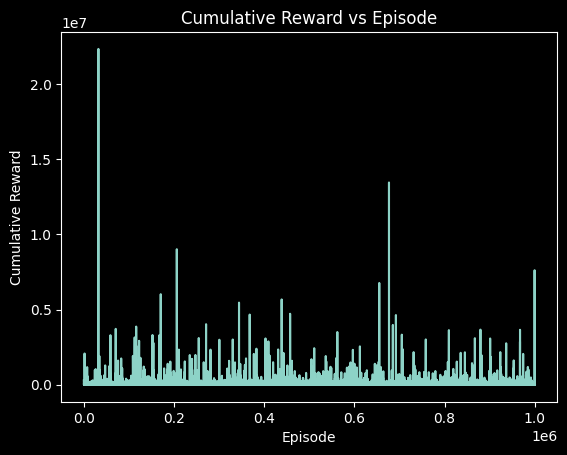

In [59]:
num_episodes = 1000000

rewards = agent.train(num_episodes)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward vs Episode')
plt.show()


### After training the Q-learning agent, we can extract symbolic knowledge in the form of IF-THEN rules from the learned Q-table. We can cluster states based on their Q-values and generate rules that represent the best action for a given cluster.

Here's an algorithm to extract symbolic knowledge from the learned Q-table:

1. Normalize the Q-values in the Q-table.
2. Perform k-means clustering on the normalized Q-values to group similar states.
3. For each cluster, generate an IF-THEN rule that represents the best action for the states in the cluster.

In [61]:
# Normalize the Q-values in the Q-table
q_values = [vals for vals in agent.q_table.values()]
normalized_q_values = np.array(q_values) / np.max(q_values)

# Perform k-means clustering on the normalized Q-values
k = 20
kmeans = KMeans(n_clusters=k, n_init=10,
                random_state=0).fit(normalized_q_values)

# Generate IF-THEN rules for each cluster
rules = []
for cluster_idx in range(k):
    cluster_states = [(state, agent_pos) for ((state, agent_pos), label) in zip(
        agent.q_table.keys(), kmeans.labels_) if label == cluster_idx]
    cluster_actions = [np.argmax(q_vals) for q_vals in kmeans.cluster_centers_]

    rule = {
        'states': cluster_states,
        'action': cluster_actions[cluster_idx],
    }
    rules.append(rule)

# Write the output to a text file
with open('output.txt', 'w') as file:
    for rule in rules:
        file.write('IF\n\n')
        for state, agent_pos in rule['states']:
            grid = np.array(state).reshape(env.grid_size, env.grid_size)
            grid[agent_pos] = 4
            for row in grid:
                file.write(" ".join(["." if cell == 0 else "X" if cell ==
                           1 else "S" if cell == 2 else "C" if cell == 3 else "A" for cell in row]))
                file.write('\n')
            file.write('\n')
        file.write(
            f"THEN {['Up', 'Down', 'Left', 'Right'][rule['action']]}\n\n")
        file.write("----------\n\n")

print("Output written to 'output.txt' successfully!")


Output written to 'output.txt' successfully!


### Now we have a set of IF-THEN rules* that represent the Q-learning agent's policy. Each rule maps a set of states (represented by their flattened grid) to the best action for those states.

##### **The quality of the extracted rules depends on the chosen clustering algorithm, the number of clusters, and how well the agent learned the optimal policy. We might need to experiment with different parameters and algorithms to find the best approach for our specific problem.*

### Now, let's create a `RuleValidator` class in order to analyze and validate our extracted symbolic knowledge.

In [22]:
class RuleValidator:
    def __init__(self, env, rules_file):
        self.env = env
        self.rules = self.read_rules_from_file(rules_file)

    def read_rules_from_file(self, filename):
        rules = []
        with open(filename, 'r') as file:
            lines = file.readlines()
    
        rule = {'states': [], 'action': None}
        state = []
        agent_pos = (None, None)
        for line in lines:
            stripped_line = line.strip()

            if stripped_line.startswith("IF"):
                if rule['states']:  # If it's not the first rule
                    rules.append(rule)
                    rule = {'states': [], 'action': None}
            elif stripped_line.startswith("THEN"):
                action_str = stripped_line.split()[1]
                rule['action'] = {"Up": 0, "Down": 1, "Left": 2, "Right": 3}[action_str]
            elif stripped_line and not stripped_line.startswith("-"):
                state_line = list(map(lambda cell: {"A": 4, ".": 0, "X": 1, "S": 2, "C": 3}[cell], stripped_line.split()))
                state.append(state_line)
            elif state:  # empty line after a state
                for i in range(len(state)):
                    for j in range(len(state[i])):
                        if state[i][j] == 4:  # If it's the agent's cell
                            agent_pos = (i, j)
                            state[i][j] = 0  # Set the cell to empty as the agent's position is already stored
                rule['states'].append((np.array(state), agent_pos))  # add a copy of the state to the rule
                state = []
                agent_pos = (None, None)
            
        # Add the last rule
        if rule['states']:
            rules.append(rule)
        return rules

    def print_rules(self, rules):
        for rule in rules:
            print("IF\n")
            for state, agent_pos in rule['states']:
                for i, row in enumerate(state):
                    row_str = []
                    for j, cell in enumerate(row):
                        if (i, j) == agent_pos:
                            row_str.append("A")
                        else:
                            row_str.append("." if cell == 0 else "X" if cell == 1 else "S" if cell == 2 else "C" if cell == 3 else ".")
                    print(" ".join(row_str))
                print()
            print(f"THEN {['Up', 'Down', 'Left', 'Right'][rule['action']]}\n")
            print("----------\n")

    def validate_rules(self):
        valid_count = 0
        obstacle_violation_count = 0
        static_violation_count = 0

        for rule in self.rules:
            for state, agent_pos in rule['states']:
                self.env.grid = state.copy()
                self.env.agent_pos = agent_pos

                # Keep a copy of the initial environment state
                initial_state = self.env.grid.copy()
                initial_agent_pos = self.env.agent_pos
                initial_survivors = self.env.survivors.copy()

                # Print the rule
                print("Validating Rule:\n")
                print("IF\n")
                for i, row in enumerate(state):
                    row_str = []
                    for j, cell in enumerate(row):
                        if (i, j) == agent_pos:
                            row_str.append("A")
                        else:
                            row_str.append("." if cell == 0 else "X" if cell == 1 else "S" if cell == 2 else "C" if cell == 3 else ".")
                    print(" ".join(row_str))
                print()
                print(f"THEN {['Up', 'Down', 'Left', 'Right'][rule['action']]}\n")

                # Take the action according to the rule
                _, reward, _, info = self.env.step(rule['action'])

                # Compare the initial and new environment state
                state_changed = not np.array_equal(initial_state, self.env.grid) or initial_agent_pos != self.env.agent_pos
                survivors_rescued = len(initial_survivors) > len(self.env.survivors)
                hit_obstacle = info['hit_obstacle']

                if state_changed:
                    if survivors_rescued:
                        valid_count += 1
                        print("State-action pair is valid because it rescued a survivor.\n")
                    else:
                        if hit_obstacle:
                            obstacle_violation_count += 1
                            print("State-action pair is invalid because it hit an obstacle.\n")
                        else:
                            valid_count += 1
                            print("State-action pair is valid because it moved to an empty cell.\n")
                else:
                    static_violation_count += 1
                    print("State-action pair is a violation because it didn't move.\n")

                print("Next State:\n")
                for i, row in enumerate(self.env.grid):
                    row_str = []
                    for j, cell in enumerate(row):
                        if (i, j) == self.env.agent_pos:
                            row_str.append("A")
                        else:
                            row_str.append("." if cell == 0 else "X" if cell == 1 else "S" if cell == 2 else "C" if cell == 3 else ".")
                    print(" ".join(row_str))
                print()
                print(f"Reward: {reward}\n")
                print("----------\n")

                # Reset the environment to the initial state
                self.env.grid = initial_state
                self.env.agent_pos = initial_agent_pos
                self.env.survivors = initial_survivors

        total_count = valid_count + obstacle_violation_count + static_violation_count

        valid_percentage = valid_count / (total_count) * 100
        obstacle_violation_percentage = obstacle_violation_count / (total_count) * 100
        static_violation_percentage = static_violation_count / (total_count) * 100

        self.visualize_validation_results(valid_percentage, obstacle_violation_percentage, static_violation_percentage)
        
        print(f"Valid: {valid_percentage}%, Violations: {obstacle_violation_percentage + static_violation_percentage}%\n")

        return valid_percentage, obstacle_violation_percentage, static_violation_percentage

    def visualize_validation_results(self, valid_percentage, obstacle_violation_percentage, static_violation_percentage):
        categories = ['Valid', 'Invalid']
        valid_percentages = [valid_percentage]
        invalid_percentages = [obstacle_violation_percentage, static_violation_percentage]

        # Set custom colors for each category
        valid_color = 'green'
        obstacle_color = 'red'
        movement_color = 'gray'

        # Plotting valid bars with green color
        plt.bar(categories[0], valid_percentages[0], color=valid_color, label='Valid')

        # Plotting invalid bars with different colors
        plt.bar(categories[1], invalid_percentages[0], color=obstacle_color, label='Obstacle Hit')
        plt.bar(categories[1], invalid_percentages[1], bottom=invalid_percentages[0], color=movement_color, label='No Movement')

        plt.xlabel('Categories')
        plt.ylabel('Percentage')
        plt.title('Validation Results')
        plt.legend()
        plt.show()


### So let's run the `RuleValidator` on our extracted rules. The validator will analyze the rules and generate a report that contains a bar chart of the number of rules that are valid and invalid.

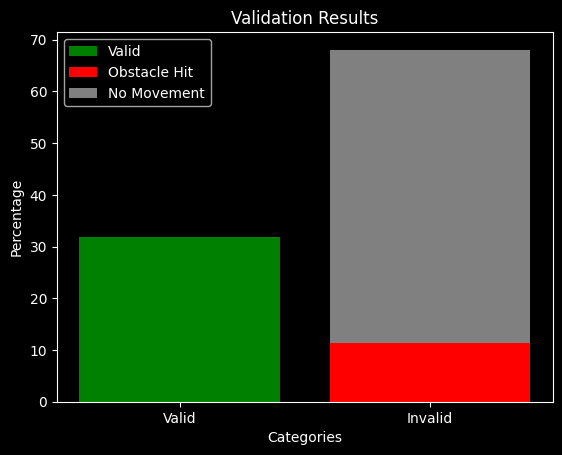

Valid: 31.924424351333613%, Violations: 68.07557564866639%



(31.924424351333613, 11.384596642414536, 56.69097900625185)

In [23]:
env = DisasterZone(grid_size=4, num_obstacles=5, num_survivors=4,
                   num_charging_stations=2, max_battery_life=20)

validator = RuleValidator(env, 'output.txt')

validator.validate_rules()
